In [18]:
import pandas as pd

data = pd.read_csv('../data/processed/processed_reweighted.csv')

In [19]:
from sklearn.cluster import AgglomerativeClustering
import itertools

affinities = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkages = ['complete', 'average', 'single', 'ward']
combinations = list(itertools.product(affinities, linkages[:-1]))

# Ward can only be combined with euclidean distance
combinations.append(('euclidean','ward'))


In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
import math
scores = []
thresholds = [i/10 for i in range(1,101)]

for affinity, linkage in combinations: 
    for threshold in thresholds: 
        ac = AgglomerativeClustering(n_clusters=None, affinity=affinity, linkage=linkage, distance_threshold=threshold)
        prediction = ac.fit_predict(X=data)
        if ac.n_clusters_ == 1 or ac.n_clusters_ == len(data):
            sc, db, ch = -math.inf,math.inf, -math.inf
        else:
            sc = silhouette_score(data, prediction)
            db = davies_bouldin_score(data, prediction)
            ch = calinski_harabasz_score(data, prediction)
        scores.append((affinity, linkage, threshold, sc, db, ch, prediction, ac.n_clusters_))


In [21]:
tested_affinities, tested_linkages, thresholds, scs, dbs, chs, predictions, n_clusters = zip(*scores)

In [22]:
placings_per_alt = {}

for i in range(len(scores)):
    placings_per_alt[(tested_affinities[i],tested_linkages[i],thresholds[i])] = {
        'affinity': tested_affinities[i],
        'linkage': tested_linkages[i],
        'threshold': thresholds[i],
        'silhouette coefficient': scs[i],
        'davies-bouldin index': dbs[i],
        'calinski-harabasz index': chs[i],
        'prediction': predictions[i],
        'clusters': n_clusters[i]
    }

sorted_by_max_sc = sorted(scores, key=lambda score:score[3], reverse=True)
sorted_by_min_db = sorted(scores, key=lambda score:score[4], reverse=False)
sorted_by_max_ch = sorted(scores, key=lambda score:score[5], reverse=True)

for index, score in enumerate(sorted_by_max_sc):
    placings_per_alt[(score[0],score[1],score[2])]['max_sc'] = index

for index, score in enumerate(sorted_by_min_db):
    placings_per_alt[(score[0],score[1],score[2])]['min_db'] = index

for index, score in enumerate(sorted_by_max_ch):
    placings_per_alt[(score[0],score[1],score[2])]['max_ch'] = index



In [23]:

def overall_placing(score):
    alt = placings_per_alt[(score[0],score[1],score[2])]
    return (alt['max_sc']+alt['min_db']+alt['max_ch'])/3

sorted_scores_on_overall = sorted(scores, key=lambda score: overall_placing(score), reverse=False)

for index, score in enumerate(sorted_scores_on_overall):
    placings_per_alt[(score[0],score[1],score[2])]['overall'] = index

In [24]:
alts = sorted(placings_per_alt.values(),key=lambda alt:alt['overall'])
alts_list = [alt.values() for alt in alts]

In [25]:
sorted_test_affinities, sorted_test_linkasges, sorted_thresholds, sorted_scs, sorted_dbs, sorted_chs, sorted_predictions, sorted_clusters, sorted_placing_sc, sorted_placing_db, sorted_placing_ch, sorted_overall = zip(*alts_list)

In [26]:
def points_in_clusters(distribution):
    amount_of_points_in_cluster = {}
    for cluster_id in distribution:
        if cluster_id in amount_of_points_in_cluster:
            amount_of_points_in_cluster[cluster_id] += 1
        else:
            amount_of_points_in_cluster[cluster_id] = 1
    return tuple(amount_of_points_in_cluster.values())

In [42]:
def print_info(i):
    print(f'Place {sorted_overall[i]:>2}. Hyperparameters: {sorted_test_affinities[i]:>9}, {sorted_test_linkasges[i]:>8}, {sorted_thresholds[i]}. Clusters: {sorted_clusters[i]:>3}. Scores: SC {sorted_scs[i]:.2f}, DB {sorted_dbs[i]:.2f}, CH {sorted_chs[i]:>6.2f}') 

In [43]:
top_amount = 30

for i in range(top_amount):
    print_info(i)

Place  0. Hyperparameters: euclidean,  average, 2.3. Clusters:   2. Scores: SC 0.45, DB 0.40, CH   5.50
Place  1. Hyperparameters: euclidean,  average, 2.4. Clusters:   2. Scores: SC 0.45, DB 0.40, CH   5.50
Place  2. Hyperparameters:        l2,  average, 2.3. Clusters:   2. Scores: SC 0.45, DB 0.40, CH   5.50
Place  3. Hyperparameters: euclidean, complete, 0.1. Clusters: 209. Scores: SC 0.01, DB 0.04, CH 430.93
Place  4. Hyperparameters:        l2,  average, 2.4. Clusters:   2. Scores: SC 0.45, DB 0.40, CH   5.50
Place  5. Hyperparameters: euclidean,   single, 0.1. Clusters: 209. Scores: SC 0.01, DB 0.04, CH 430.93
Place  6. Hyperparameters:        l1, complete, 0.2. Clusters: 209. Scores: SC 0.01, DB 0.04, CH 430.93
Place  7. Hyperparameters:        l1,   single, 0.2. Clusters: 209. Scores: SC 0.01, DB 0.04, CH 430.93
Place  8. Hyperparameters: euclidean,  average, 0.1. Clusters: 209. Scores: SC 0.01, DB 0.04, CH 430.93
Place  9. Hyperparameters:        l1, complete, 0.3. Clusters: 2

In [29]:
for i in range(top_amount):
    print(f'Place {sorted_overall[i]}. Hyperparameters: {sorted_test_affinities[i]:>9}, {sorted_test_linkasges[i]:>8}, {sorted_thresholds[i]}. Points in each cluster: {points_in_clusters(sorted_predictions[i])}')

Place 0. Hyperparameters: euclidean,  average, 2.3. Points in each cluster: (209, 1)
Place 1. Hyperparameters: euclidean,  average, 2.4. Points in each cluster: (209, 1)
Place 2. Hyperparameters:        l2,  average, 2.3. Points in each cluster: (209, 1)
Place 3. Hyperparameters: euclidean, complete, 0.1. Points in each cluster: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
Place 4. Hyperparameters:        l2,  ave

In [30]:
def is_trivial(i):
    return sorted_clusters[i] == 209 or points_in_clusters(sorted_predictions[i])[0] == 209

In [31]:
top_no_trivial = [i for i in range(len(sorted_overall)) if not is_trivial(i)][:top_amount]

In [39]:
for i in top_no_trivial:
    print_info(i)


Place 12. Hyperparameters: euclidean, complete, 0.2. Clusters: 205. Scores: SC 0.02, DB 0.13, CH 78.71
Place 14. Hyperparameters:        l2, complete, 0.2. Clusters: 205. Scores: SC 0.02, DB 0.13, CH 78.71
Place 16. Hyperparameters: euclidean,     ward, 0.2. Clusters: 205. Scores: SC 0.02, DB 0.13, CH 78.71
Place 17. Hyperparameters: euclidean,  average, 0.2. Clusters: 205. Scores: SC 0.02, DB 0.13, CH 78.71
Place 19. Hyperparameters:        l1, complete, 7.9. Clusters:   3. Scores: SC 0.24, DB 1.13, CH 41.43
Place 21. Hyperparameters:        l2,  average, 0.2. Clusters: 205. Scores: SC 0.02, DB 0.13, CH 78.71
Place 24. Hyperparameters:        l1, complete, 8.0. Clusters:   3. Scores: SC 0.24, DB 1.13, CH 41.43
Place 27. Hyperparameters:        l1, complete, 8.1. Clusters:   3. Scores: SC 0.24, DB 1.13, CH 41.43
Place 29. Hyperparameters:        l1, complete, 8.2. Clusters:   3. Scores: SC 0.24, DB 1.13, CH 41.43
Place 31. Hyperparameters:        l1, complete, 8.3. Clusters:   3. Score

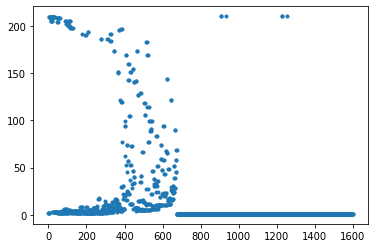

In [33]:
import matplotlib.pyplot as plt

plt.plot(sorted_overall, sorted_clusters,'.')

plt.show()

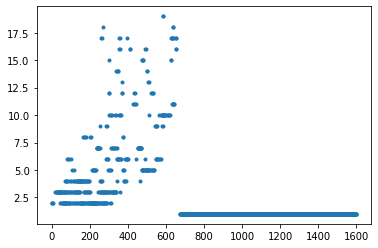

In [34]:
clusterings_under_20 = [(index, cluster_amount) for index, cluster_amount in enumerate(sorted_clusters) if cluster_amount < 20 ]

indexes_u20, cluster_amount_u20 = zip(*clusterings_under_20)

import matplotlib.pyplot as plt

plt.plot(indexes_u20, cluster_amount_u20,'.')

plt.show()